In [5]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pickle, time

from numba import njit

In [6]:


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 8  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [80]:
def get_hopping_NN(NN, k):
    if NN in np.array([(1,2), (3, 4), (7,8), (5, 6)])-1:
        return np.exp(-1j*a[1]@k)
    elif NN in np.array([(6, 1), (8, 3), (4, 7), (2, 5)])-1:
        return np.exp(1j*a[0]@k)
    elif NN in np.array([(2, 3), (4,1), (6, 7), (8,5)])-1:
        return np.exp(1j*a[2]@k)
    else:
        return "Error"

def get_hopping_NNN(NNN, k):
    if NNN in np.array([(1,3), (5, 7), (2, 4), (6, 8)])-1:
        return np.exp(1j*b[0]@k)
    elif NNN in np.array([(1, 5), (3, 7), (2, 6), (4, 8)])-1:
        return np.exp(1j*b[1]@k)
    elif NNN in np.array([(2, 8), (1, 7), (3, 5), (4, 6)])-1:
        return np.exp(1j*b[2]@k)
        

In [81]:
#Generate hamiltonian for 2x2x2 orbital Kane-Mele model

NN_list = np.array([(1,2), (3, 4), (7,8), (5, 6), (6, 1), (8, 3), (4, 7), (2, 5), (2, 3), (4,1), (6, 7), (8,5)]) - 1
NNN_list = np.array([(1, 3), (5, 7), (1, 5), (1, 7), (3, 5), (3, 7), (2, 8), (4, 6), (2, 4), (6, 8), (2, 6), (4, 8)]) - 1

a = np.array([[1, 0],[-1/2, np.sqrt(3)/2],[-1/2, -np.sqrt(3)/2]])
b = np.array([[0, np.sqrt(3)],[3/2, -np.sqrt(3)/2],[-3/2, -np.sqrt(3)/2]])


def hamil(t, mu, U, l_so, phi_h, k):
    hamiltonian = sp.csr_matrix((2**N, 2**N), dtype=complex)
    for NN in NN_list:
        hamiltonian+=(cdags[NN[1]]@cs[NN[0]]*get_hopping_NN(NN, k) + cdags[NN[0]]@cs[NN[1]]*np.conj(get_hopping_NN(NN, k)))*t
        hamiltonian+=cdags[NN[0]]@cs[NN[0]]@cdags[NN[1]]@cs[NN[1]]*U
    for NNN in NNN_list:
        hamiltonian+=(1j*cdags[NNN[0]]@cs[NNN[1]] - 1j*cdags[NNN[1]]@cs[NNN[0]])*-l_so*2*get_hopping_NNN(NNN, k).real*np.sin(phi_h)
    for i in range(N):
        hamiltonian+=(mu+np.cos(phi_h))*(cdags[i]@cs[i])
    
    return hamiltonian

In [82]:
hamil(1, 0, 10, 0.3, np.pi/4, np.array([1,1]))

<256x256 sparse matrix of type '<class 'numpy.complex128'>'
	with 3327 stored elements in Compressed Sparse Row format>

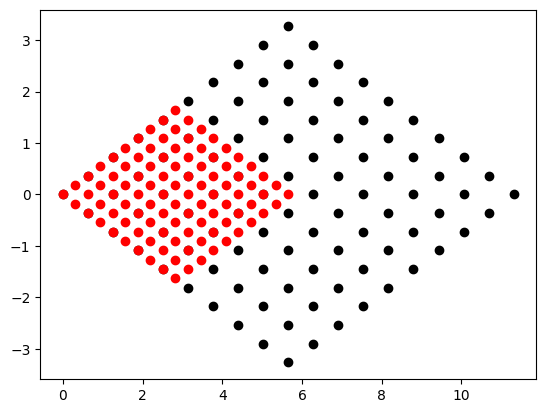

In [13]:
b1 = np.array([np.sqrt(3)/2, 1/2])*4*np.pi/np.sqrt(3)
b2 = np.array([np.sqrt(3)/2, -1/2])*4*np.pi/np.sqrt(3)

def get_BZ_points(k_num):
    k_points = []
    for n in range(k_num):
        for m in range(k_num):
            k_points.append(b1*n/k_num+b2*m/k_num)

    return k_points

for k in get_BZ_points(10):
    plt.scatter(k[0], k[1], c='k')

br1 = np.array([np.sqrt(3), -1])*np.pi/np.sqrt(3)
br2 = np.array([0, 2])*np.pi/np.sqrt(3)

def get_redBZ_points(k_num):
    k_points = []
    for n in range(k_num):
        for m in range(k_num):
            k_points.append(b1*n/k_num/2+b2*m/k_num/2)

    return k_points

for k in get_redBZ_points(10):
    plt.scatter(k[0], k[1], c='red')

In [14]:
num_op = sp.csr_matrix((2**N, 2**N), dtype=complex)
for i in range(N):
    num_op+=cdags[i]@cs[i]

#evals, evecs = sp.linalg.eigsh(num_op[m_indices, :][:, m_indices], return_eigenvectors=True, which='SM', k=10)
#evals

np.linalg.eigvalsh(num_op.toarray())

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6.,
       6., 6., 6., 6., 6.

In [55]:
U_list = np.array([8])#np.arange(0, 8, 0.1)
t = 1
l_so = -0.1
k_num = 10

U = 0
mu_range = np.linspace(U/2-2, U/2+2, 40)
occ_num = np.zeros(shape=(len(U_list), len(mu_range)))
BZ_points = get_redBZ_points(k_num)

for U_ind, U in enumerate(U_list):
    print(U)
    mu_range = np.linspace(-2, 2, 40)
    for mu_ind, mu in enumerate(mu_range):
        print(mu_ind)
        occ_list = np.zeros(k_num**2)
        for ind, k in enumerate(BZ_points):
            hamil_k = hamil(t, mu, U, l_so, k)
            evals, evecs = sp.linalg.eigsh(hamil_k, which='SA', k=6)
            #print(evals)
            occ_list[ind] = (np.conj(evecs[:,0].T)@num_op@ evecs[:,0]).real
            #print((np.conj(evecs[:,0].T)@num_op@ evecs[:,0]).real)
        occ_num[U_ind, mu_ind] = (occ_list.sum()/k_num**2)

8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Text(0.5, 0, '$\\mu$')

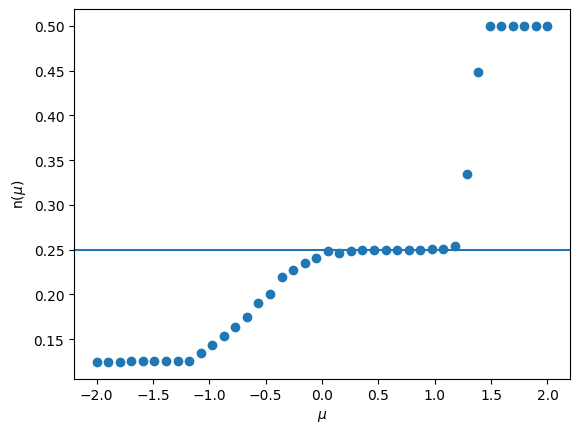

In [66]:
#U_list = np.arange(0, 8, 0.1)
#occ_num = np.load("occ_num_testhalffill.npy")
mu_half_fill = []

for U_ind, U in enumerate(U_list[:]):
    mu_range = np.linspace(-2, 2, 40)
    plt.scatter(mu_range, occ_num[U_ind, :]/8)


plt.axhline(y=0.25)
plt.ylabel(r"n($\mu$)")
plt.xlabel(r"$\mu$")

In [42]:
import itertools

def get_m_basis_indices(N, M):
    """
    Generate the indices of the M-particle sector in the full Hilbert space.
    
    Parameters:
    N (int): Number of orbitals.
    M (int): Number of particles.
    
    Returns:
    list: Sorted list of indices in the full Hilbert space.
    """
    total_modes = N
    m_indices = []
    for bits in itertools.combinations(range(total_modes), M):
        index = 0
        for q in bits:
            # Reverse mode order to match the Kronecker product ordering
            pos = total_modes - 1 - q
            index += (1 << pos)
        m_indices.append(index)
    return sorted(m_indices)

# Example usage:
N = 8
M = 7  # Choose your desired particle number sector

# Generate the indices for the M-particle sector
m_indices = get_m_basis_indices(N, M)

# Assuming H is your Hamiltonian constructed as a sparse matrix in the full space
# Project H into the M-particle sector
#H_m = H[m_indices, :][:, m_indices]

# Convert to a dense matrix if needed (be cautious with memory)
# H_m_dense = H_m.toarray()

In [43]:
num_op = sp.csr_matrix((2**N, 2**N), dtype=complex)
for i in range(N):
    num_op+=cdags[i]@cs[i]

evals, evecs = sp.linalg.eigsh(num_op[m_indices, :][:, m_indices], return_eigenvectors=True, which='SM', k=4)
evals

array([1., 1., 1., 1.])

In [75]:
U_list = np.array([8])#np.arange(0, 8, 0.1)
t = 1
l_so = 0
k_num = 20

U = 0
mu = 0
BZ_points = get_redBZ_points(k_num)
eigenenergies = np.zeros(shape=(len(BZ_points), 6))

for ind, k in enumerate(BZ_points):
    hamil_k = hamil(t, mu, U, l_so, np.pi/2, k)[m_indices, :][:, m_indices]
    evals, evecs = sp.linalg.eigsh(hamil_k, which='SA', k=6)
    eigenenergies[ind, :] = np.sort(evals)

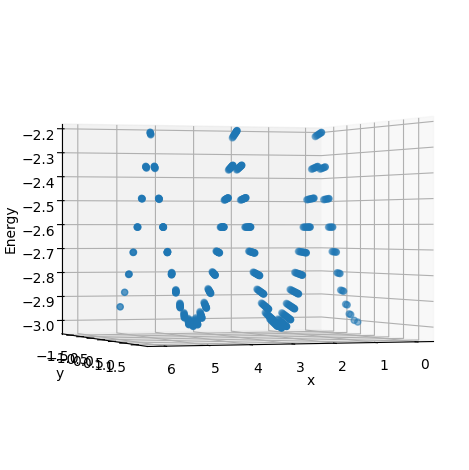

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (keeps IDEs quiet)

# --- Your data ------------------------------------------------------------
coords   = BZ_points   # list of (x, y) tuples
energies = eigenenergies[:,0]              # same length as coords
# --------------------------------------------------------------------------

# Unpack the tuples
xs, ys = zip(*coords)
zs      = energies

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, marker='o')      # ↩ basic 3-D scatter

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Energy')
# look almost horizontally, from the +y direction
ax.view_init(elev=0, azim=70)      # elev=0 gives a perfectly edge-on slice


plt.tight_layout()
plt.show()
